In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from utils.preprocessing import mask_shapefile

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Function to normalize image to [0, 1]
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

## Metrics

In [3]:
from sklearn.metrics import mean_squared_error
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim

In [4]:
# Computes MSE between img1 and img2
def show_metrics(img1, img2):
    img1_np = np.array(img1)
    img2_np = np.array(img2)

    img1_flat = img1_np.flatten()
    img2_flat = img2_np.flatten()

    # Compute MSE
    mse = mean_squared_error(img1_flat, img2_flat)
    print(f"Mean Squared Error between the images: {mse}")

    # Compute SSIM
    img1_normalized = normalize_image(img1_np)
    img2_normalized = normalize_image(img2_np)

    ssim_value, ssim_map = ssim(img1_normalized, img2_normalized, data_range=1.0, full=True)
    print(f"SSIM: {ssim_value}")
    
    # Display the SSIM map
    plt.imshow(ssim_map, cmap='gray')
    plt.title(f'SSIM Map (SSIM Value: {ssim_value:.4f})')
    plt.colorbar()
    plt.show()

## Results from Zaragoza City Hall

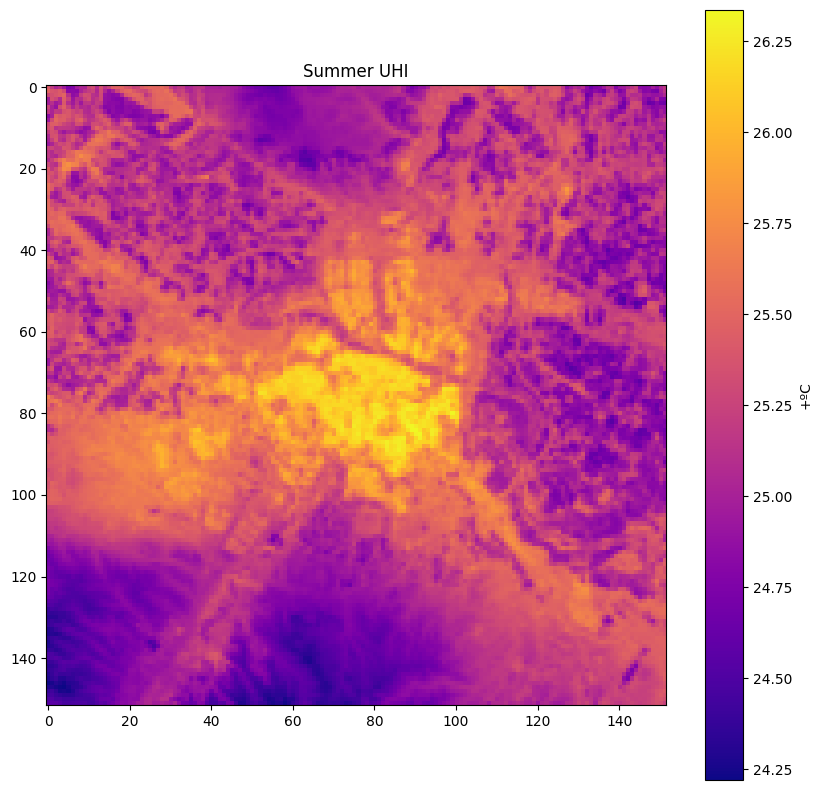

In [5]:
summer_uhi_path = '../data/2023_tmed_ver.tif'

with rasterio.open(summer_uhi_path) as summer_uhi:
    no_data_value = summer_uhi.nodata
    summer_uhi_band = summer_uhi.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(summer_uhi_band, cmap='plasma')
plt.colorbar(label='+ºC')
plt.title(f'Summer UHI')
plt.show()

In [6]:
summer_uhi_masked_path = '../data/2023_summer_masked.tif'
mask_shapefile('../data/shapefiles/zaragoza_outline.shp', summer_uhi_path, summer_uhi_masked_path, 0)

Shapefile CRS: EPSG:32630
Input CRS EPSG:25830


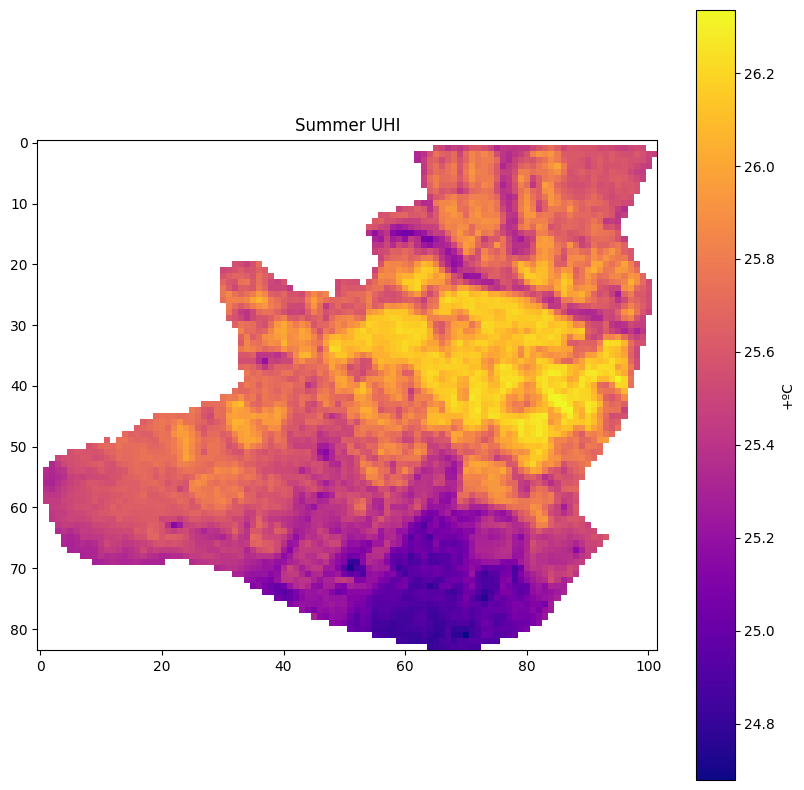

In [7]:
with rasterio.open(summer_uhi_masked_path) as summer_uhi:
    no_data_value = summer_uhi.nodata
    summer_uhi_band = summer_uhi.read(1)

# Mask clusters where original band had no-data
summer_uhi_band = np.ma.masked_where(summer_uhi_band == no_data_value, summer_uhi_band)
summer_uhi_band = summer_uhi_band[:-1]

plt.figure(figsize=(10, 10))
plt.imshow(summer_uhi_band, cmap='plasma')
plt.colorbar(label='+ºC')
plt.title(f'Summer UHI')
plt.show()

In [8]:
summer_uhi_band.shape

(84, 102)

## Own results with buildings

In [9]:
from rasterio.enums import Resampling

In [10]:
summer_uhi_masked_path = '../data/swir2_average.tif'

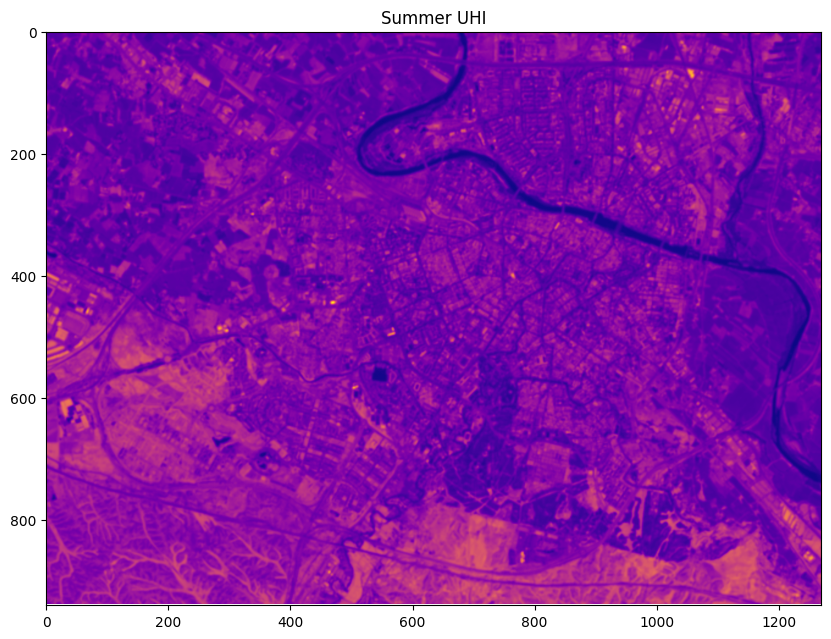

In [11]:
with rasterio.open(summer_uhi_masked_path) as src:
    no_data_value = src.nodata
    swir2_band = src.read(1)

    # Define transformation and output resolution
    transform = src.transform
    new_resolution = 100  # Desired resolution in meters
    old_resolution = src.res[0]  # Original resolution (20m)
    
    # Compute new size
    scale = old_resolution / new_resolution
    new_width = int(src.width * scale)
    new_height = int(src.height * scale)

    # Define new transformation
    new_transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )

    resampled_data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.bilinear
    )

    # Prepare metadata for export
    metadata = src.meta.copy()
    metadata.update({
        'driver': 'GTiff',
        'height': new_height,
        'width': new_width,
        'transform': new_transform,
        'nodata': no_data_value,
        'dtype': resampled_data.dtype
    })

# Mask clusters where original band had no-data
swir2_band = np.ma.masked_where(swir2_band == no_data_value, swir2_band)

plt.figure(figsize=(10, 10))
plt.imshow(swir2_band, cmap='plasma')
plt.title(f'Summer UHI')
plt.show()

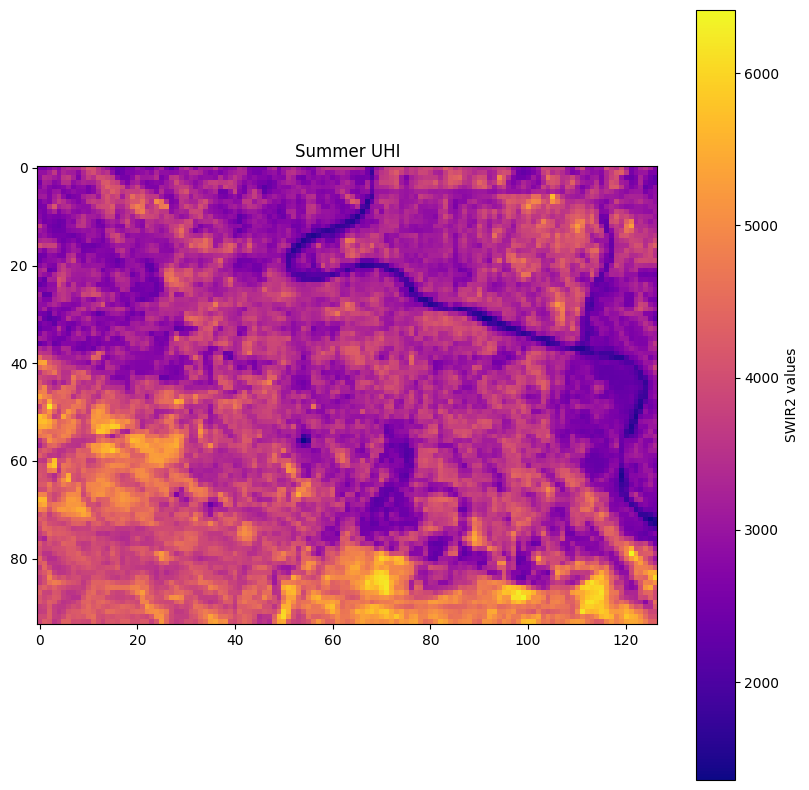

In [12]:
# Mask clusters where original band had no-data
resampled_data = np.ma.masked_where(resampled_data == no_data_value, resampled_data)

plt.figure(figsize=(10, 10))
plt.imshow(resampled_data, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title(f'Summer UHI')
plt.show()

In [13]:
# Export masked result
swir2_raw_path = '../data/swir2_average_upscaled_raw.tif'
with rasterio.open(swir2_raw_path, 'w', **metadata) as dest:
    dest.write_band(1, resampled_data)

In [14]:
swir2_corrected_path = '../data/swir2_average_upscaled_corrected.tif'
mask_shapefile('../data/shapefiles/zaragoza_outline.shp', swir2_raw_path, swir2_corrected_path, 0)

Shapefile CRS: EPSG:32630
Input CRS EPSG:32630


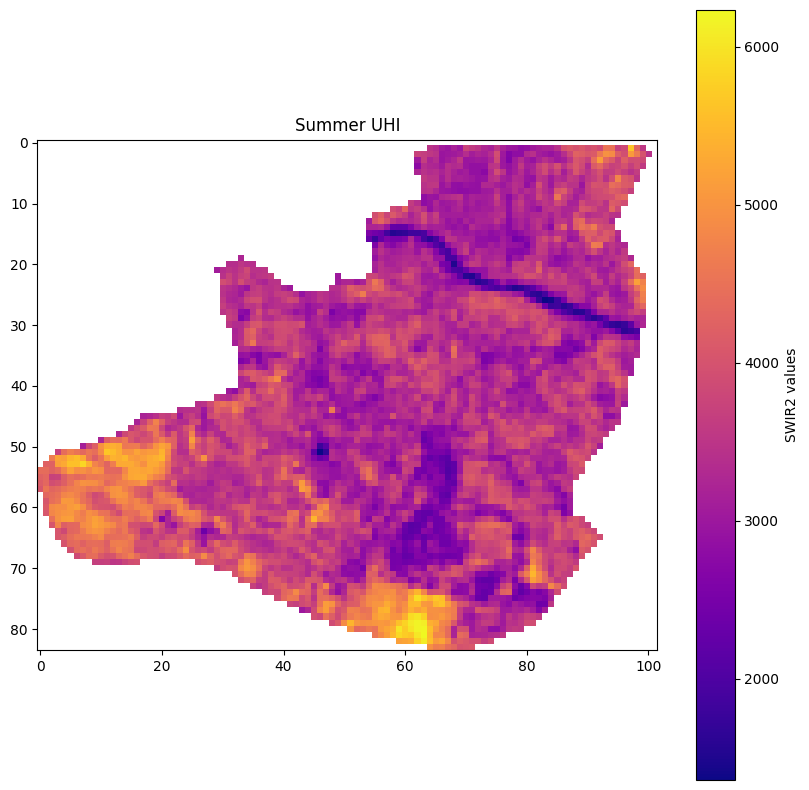

In [15]:
with rasterio.open(swir2_corrected_path) as src:
    no_data_value = src.nodata
    swir2_band = src.read(1)

swir2_band = np.ma.masked_where(swir2_band == no_data_value, swir2_band)

plt.figure(figsize=(10, 10))
plt.imshow(swir2_band, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title(f'Summer UHI')
plt.show()

In [16]:
swir2_band.shape

(84, 102)

Mean Squared Error between the images: 7598533.5
SSIM: 0.49504940917526813


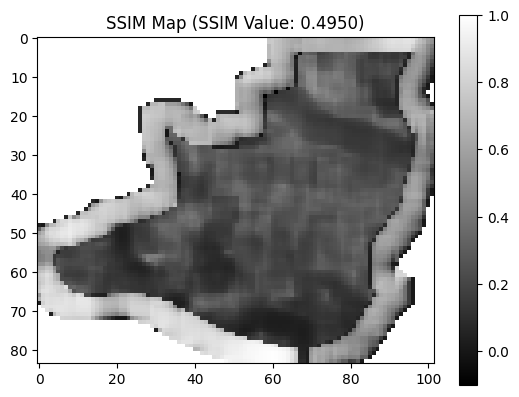

In [17]:
show_metrics(summer_uhi_band, swir2_band)

## Own results without buildings

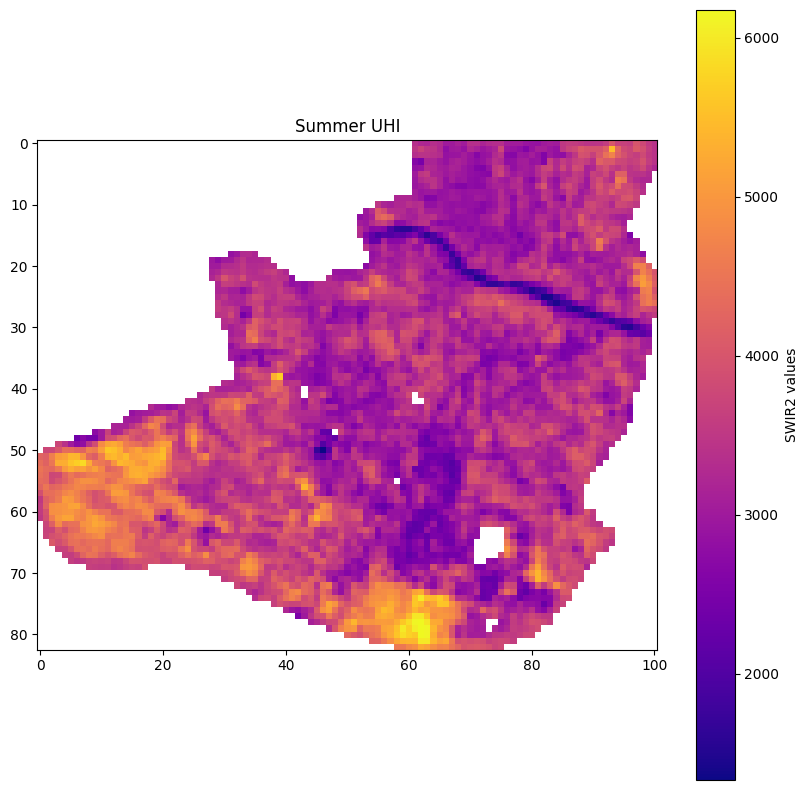

In [18]:
swir2_path = '../data/swir2_average_without_buildings_masked.tif'
#swir2, transform = read_resample(swir2_path, 1.0)
with rasterio.open(swir2_path) as src:
    no_data_value = src.nodata
    
    # Define transformation and output resolution
    transform = src.transform
    new_resolution = 100  # Desired resolution in meters
    old_resolution = src.res[0]  # Original resolution (20m)
    
    # Compute new size
    scale = old_resolution / new_resolution
    new_width = int(src.width * scale)
    new_height = int(src.height * scale)

    # Define new transformation
    new_transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    
    resampled_data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.bilinear
    )

# Mask clusters where original band had no-data
resampled_data = np.ma.masked_where(resampled_data == no_data_value, resampled_data)

plt.figure(figsize=(10, 10))
plt.imshow(resampled_data, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title(f'Summer UHI')
plt.show()

In [20]:
resampled_data.shape

(83, 101)

In [21]:
summer_uhi_band_cropped = summer_uhi_band[:-1, :-1]
summer_uhi_band_cropped.shape

(83, 101)

Mean Squared Error between the images: 7875515.5
SSIM: 0.41222649173614306


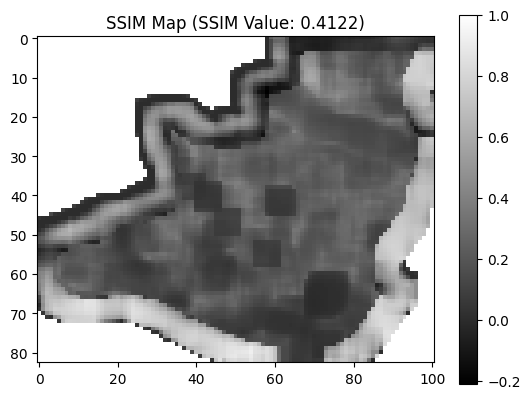

In [23]:
show_metrics(summer_uhi_band_cropped, resampled_data)

## Empty zones interpolation

In [18]:
from scipy.interpolate import griddata

/tmp/ipykernel_9293/522034468.py:24: RuntimeWarning: invalid value encountered in cast
  raster_filled[nodata_mask] = grid_z[nodata_mask]


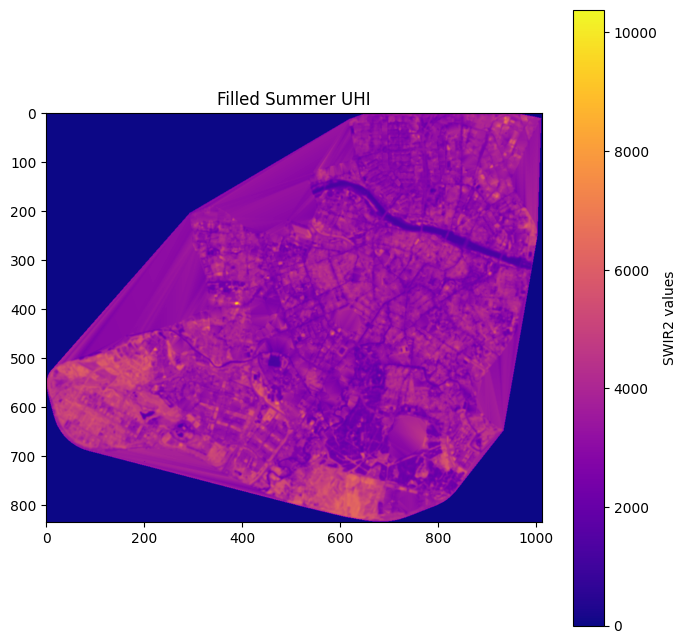

In [19]:
# Load the raster data
raster_path = '../data/swir2_average_without_buildings_masked.tif'
with rasterio.open(raster_path) as src:
    nodata_value = src.nodata
    raster_data = src.read(1)
    profile = src.profile

# Create no data mask
nodata_mask = raster_data == nodata_value

# Get the coordinates and values of the known data points
x_coords, y_coords = np.meshgrid(np.arange(raster_data.shape[1]), np.arange(raster_data.shape[0]))
known_data_mask = ~nodata_mask
x_known = x_coords[known_data_mask]
y_known = y_coords[known_data_mask]
values_known = raster_data[known_data_mask]

# Perform griddata interpolation
points = np.column_stack((x_known, y_known))
grid_z = griddata(points, values_known, (x_coords, y_coords), method='linear')

# Fill the gaps in the original raster
raster_filled = raster_data.copy()
raster_filled[nodata_mask] = grid_z[nodata_mask]

# Display the filled raster data
plt.figure(figsize=(8, 8))
plt.imshow(raster_filled, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title('Filled Summer UHI')
plt.show()

# Save the filled raster data
filled_raster_path = 'filled_raster.tif'  # Replace with the desired path to save the filled raster file
with rasterio.open(filled_raster_path, 'w', **profile) as dst:
    dst.write(raster_filled, 1)

## Heat transfer simulation

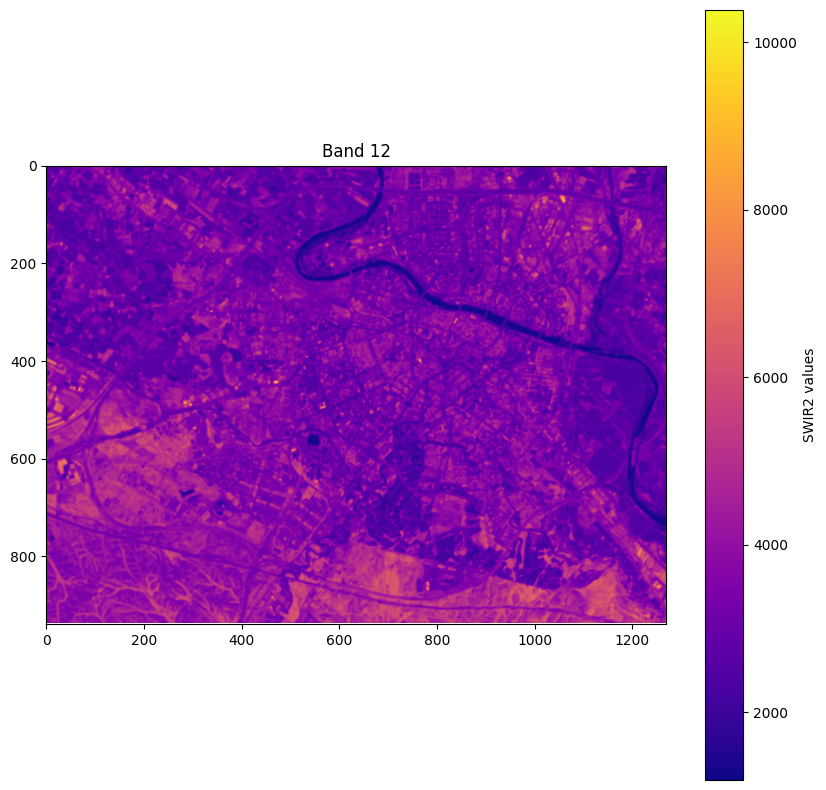

In [20]:
swir2_path = '../data/swir2_average.tif'
with rasterio.open(swir2_path) as src:
    no_data_value = src.nodata
    swir2 = src.read(1)

# Mask clusters where original band had no-data
swir2 = np.ma.masked_where(swir2 == no_data_value, swir2)

plt.figure(figsize=(10, 10))
plt.imshow(swir2, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title(f'Band 12')
plt.show()

In [21]:
# Function to compute the standard deviation in a moving window
def compute_differential(window):
    center_value = window[len(window) // 2]
    if center_value == no_data_value:
        return no_data_value
    else:
        std = np.std(window)
        mean = np.mean(window)
        if center_value <= mean: # Transference of heat
            return mean-center_value
        else:
            return 0
        #return mean-center_value
    #return np.std(window) if center_value != no_data_value else no_data_value

In [22]:
# Function to compute the average difference with surrounding pixels
'''def compute_differential(window):
    center_value = window[len(window) // 2]
    if center_value == no_data_value:
        return no_data_value
    else:
        surrounding_values = np.delete(window, len(window) // 2)
        differences = surrounding_values - center_value
        return np.mean(differences)'''

'def compute_differential(window):\n    center_value = window[len(window) // 2]\n    if center_value == no_data_value:\n        return no_data_value\n    else:\n        surrounding_values = np.delete(window, len(window) // 2)\n        differences = surrounding_values - center_value\n        return np.mean(differences)'

In [23]:
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])

In [24]:
# Function to simulate heat transfer
def heat_transfer(raster, kernel, alpha=0.1, iterations=100):
    for _ in range(iterations):
        # Convolve the raster with the kernel to get the sum of neighbors
        neighbors_sum = convolve(raster, kernel, mode='constant', cval=no_data_value)
        
        # Count the number of valid neighbors (non-no_data_value)
        valid_neighbors_count = convolve((raster != no_data_value).astype(int), kernel, mode='constant', cval=0)
        
        # Calculate the difference between the pixel and the average of its neighbors
        diff = neighbors_sum / valid_neighbors_count - raster
        
        # Update the raster values with the differential
        raster = raster + alpha * diff
        
        # Apply the no_data_value mask
        raster[raster == no_data_value] = no_data_value
    
    return raster

In [25]:
# Run the heat transfer simulation
swir2_updated = heat_transfer(swir2, kernel, alpha=0.4, iterations=1)

# Plot the original and updated rasters
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(swir2, cmap='plasma')
ax[0].set_title('Original SWIR2')

ax[1].imshow(swir2_updated, cmap='plasma')
ax[1].set_title('Convolved SWIR2')

plt.show()

NameError: name 'convolve' is not defined

In [ ]:
from scipy.ndimage import generic_filter

window_size = 3
differential = generic_filter(swir2, compute_differential, size=window_size)

In [ ]:
from scipy.ndimage import convolve

# Define the Laplacian kernel
laplacian_kernel = np.array([[0,  1, 0],
                             [1, 4, 1],
                             [0,  1, 0]])
'''laplacian_kernel = np.array([[0,  0,  1,  0,  0],
                             [0,  1,  2,  1,  0],
                             [1,  2, -16, 2,  1],
                             [0,  1,  2,  1,  0],
                             [0,  0,  1,  0,  0]])'''
'''laplacian_kernel = np.array([[0,  0,  1,  0,  0],
                             [0,  1,  2,  1,  0],
                             [1,  2,  4,  2,  1],
                             [0,  1,  2,  1,  0],
                             [0,  0,  1,  0,  0]])'''

In [ ]:
# Create a copy of the original raster to store the differential values
#differential = np.copy(swir2)

In [ ]:
# Apply convolution to get the differential with respect to surrounding pixels
'''for _ in range(1):
    differential = convolve(differential, laplacian_kernel, mode='constant', cval=no_data_value)'''

In [ ]:
#differential = np.clip(differential, -1000, 1000)

In [ ]:
# Mask clusters where original band had no-data
#differential = np.ma.masked_where(differential == no_data_value, differential)
plt.figure(figsize=(10, 10))
plt.imshow(differential, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title(f'Band 12')
plt.show()

In [ ]:
convoluted_path = '../data/swir2_convoluted.tif'
with rasterio.open(convoluted_path, 'w', **src.meta) as dest:
    dest.write(differential, 1)

In [ ]:
with rasterio.open(convoluted_path) as src:
    no_data_value = src.nodata
    
    # Define transformation and output resolution
    transform = src.transform
    new_resolution = 100  # Desired resolution in meters
    old_resolution = src.res[0]  # Original resolution (30m)
    
    # Compute new size
    scale = old_resolution / new_resolution
    new_width = int(src.width * scale)
    new_height = int(src.height * scale)

    # Define new transformation
    new_transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    
    resampled_data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.bilinear
    )

# Mask clusters where original band had no-data
resampled_data = np.ma.masked_where(resampled_data == no_data_value, resampled_data)

plt.figure(figsize=(10, 10))
plt.imshow(resampled_data, cmap='plasma')
plt.colorbar(label='SWIR2 values')
plt.title(f'Summer UHI')
plt.show()